In [16]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from importlib import reload
import GEFClassic
reload(GEFClassic)
from GEFClassic import GEF
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from mpmath import hankel1, hankel2
import pandas as pd
import source_prefac
from numpy import array, append
from scipy.linalg import inv

In [3]:
alpha = 0.
beta=25.
Mpl = 1.
M = 6.16e-6*Mpl
phi0 = 15.55*Mpl
dphidt0 = -np.sqrt(2/3)*M*Mpl
ini = {"phi":phi0, "dphi":dphidt0}
ntr = 150
H = GEF(beta, Mpl, ini, M, ntr, approx=True)

In [9]:
H.LoadData("GEF_Beta25.0_SENone_M6.16.dat")
H.Unitful()

In [10]:
k = np.array([1e5, 1e10, 1e15])*H.H0

In [35]:

# array of rv, rrho, r1pi, r2pi, rE2, rEB
def prefac_arr(G,k):
    
    # Background quantites [DGnote: Check all the GEF imported variables. Also assuming no k-dependence for GEF quantities]
    Mpl = G.Mpl
    G.Unitful()
    H  = G.vals["H"]
    a = G.vals["a"]
    Hdot = G.vals["Hprime"]
    phipr = a*G.vals["dphi"]    # phiprime
    Vpr = G.dVdphi()
    Vppr = G.ddVddphi()
    E2 = G.vals["E"]
    B2 = G.vals["B"]
    I1 = 1
    I1pr = 0
    I1ppr = 0
    I2pr = G.dIdphi()
    I2ppr = G.ddIddphi()
    EB = G.vals["G"]
    B2pr = a*G.vals["Bdot"]
    E2pr = a*G.vals["Edot"]
    EBpr = a*G.vals["Gdot"]
    EB1 = G.vals["G1"]
    phiddot = G.vals["ddphi"]


    Hddot = -1*phipr*phiddot/(a*Mpl**2) - (I1pr*phipr/(3*a*Mpl**2))*(E2 + B2) - (I1/(3*a*Mpl**2))*(E2pr + B2pr)
    


    # M matrix [Eqs. (85), (87) and (88)]
    M11 = 1
    M12 = (-1*H*phipr)/(a*Hdot*2*(Mpl**2))

    M21pre = H/(a*Hdot)
    M21fac = k**2 + 2*(a**2)*I1*B2/(3*Mpl**2)
    M21 = M21pre*M21fac
    
    M22pre = -1*H/((a**2)*a*(Hdot**2)*Mpl**2)
    M22fac1 = ((phipr**2)*(a**2)/(6*Mpl**2))*(I1pr*E2 + I2pr*EB)
    M22fac2 = (a**2/(3*Mpl**2))*I1*(E2 + B2)*(a*H*phipr + a**2*Vpr + a**2*I1pr*(E2 + B2)/6)
    M22 = M22pre*(M22fac1 + M22fac2)
    
    detM = M11*M22 - M12*M21
    Minv11 = M22/detM
    Minv12 = -M12/detM
    Minv21 = -M21/detM
    Minv22 = M11/detM

    Minvmat = array([[Minv11, Minv12], [Minv21,Minv22]])

    # derivatives of M21 and M22 used below
    M21prepr = 1 - (H**2*Hdot + H*Hddot)/(Hdot*Hdot)
    M21facpr = (2/(3*Mpl**2))*a**2*(2*a*H*I1*B2 + I1pr*phipr*B2 + I1*B2pr)
    M21pr = M21prepr*M21fac + M21pre*M21facpr

    M22prepr = (-1/Mpl**2)*(1 - 3*H + 2*H*Hddot/(Hdot**2))/(a**2*Hdot)
    M22fac1pr = (1/(6*Mpl**2))*((2*phipr*phiddot)*(a**4)*(I1pr*E2 + I2pr*EB) \
                                + (phipr**2)*(4*a**3*H)*(I1pr*E2 + I2pr*EB) \
                                    + (phipr**2)*(a**2)*(I1ppr*phipr*E2 + I1pr*E2pr + I2ppr*phipr*EB + I2pr*EBpr))
    M22fac2pr = (1/(3*Mpl**2))*((2*a**3*H*I1 + a**2*I1pr*phipr)*(E2 + B2)*(a*H*phipr + a**2*Vpr + a**2*I1pr*(E2 + B2)/6) \
                                + a**2*I1*(E2pr + B2pr)*(a*H*phipr + a**2*Vpr + a**2*I1pr*(E2 + B2)/6) \
                                + a**2*I1*(E2 + B2)*(2*a*a*H*H*phipr + a*a*Hdot*phipr + a**3*H*phiddot + 2*a**3*H*Vpr + a**2*Vppr*phipr \
                                                    +(1/6)*(2*a**3*H*I1pr*(E2+B2) + a**2*I1ppr*phipr*(E2+B2) + a**2*I1pr*(E2pr + B2pr))))
    M22pr = M22prepr*(M22fac1 + M22fac2) + M22pre*(M22fac1pr + M22fac2pr)
 


    # c coefficients [Eqs. (85) and (89)-(91)]
    c1v = (-1*H)/(a*Hdot)
    c1rho = np.zeros(c1v.shape)
    c1pi = np.zeros(c1v.shape)
    c1arr = array([c1v, c1rho, c1pi])   # array of c1v, c1rho and c1pi in that order

    c2vpre = H/((Mpl**2)*a*(Hdot**2))
    c2vfac1 = phipr*(Vpr - (I1pr*(E2 - B2))/6 - (I2pr*EB)/3)
    c2vfac2 = (-2/3)*a*H*I1*(E2 + B2)
    c2v = c2vpre*(c2vfac1 + c2vfac2)
    c2rho = (2/3)*H/(a*Hdot)
    c2pi = (2/3)*(H/(a*Hdot))*(k**2 + a*a*I1*E2/(Mpl**2))
    c2arr = array([c2v, c2rho, c2pi])   # array of c2v, c2rho and c2pi in that order

    # derivatives of c2 coefficients used below
    c2vprepr = (1/Mpl**2)*(1 - (H*H*Hdot + 2*H*Hddot)/(Hdot**2))/Hdot
    c2vfac1pr = (a*H*phipr + a*a*phiddot)*(Vpr - (I1pr*(E2 - B2))/6 - (I2pr*EB)/3) \
        + phipr*(Vppr*phipr - (I1ppr*phipr*(E2 - B2) + I1pr*(E2pr - B2pr))/6 - (I2ppr*phipr*EB + I2pr*EBpr)/3)
    c2vfac2pr = (-2/3)*(a*a*H*H*I1*(E2 + B2) + a*a*Hdot*I1*(E2 + B2) + a*H*I1pr*phipr*(E2 + B2) + a*H*I1*(E2pr + B2pr))
    c2vpr = c2vprepr*(c2vfac1 + c2vfac2) + c2vpre*(c2vfac1pr + c2vfac2pr)
    c2rhopr = (2/3)*(1 - H*H/Hdot + H*Hddot/(Hdot*Hdot))
    c2pipr = (2/3)*(1 - H*H/Hdot + H*Hddot/(Hdot*Hdot))*(k**2 + a*a*I1*E2/(Mpl**2)) \
        + (2/3)*(H/(a*Hdot))*(2*a**3*H*I1*E2 + a*a*I1pr*phipr*E2 + a*a*I1*E2pr)/Mpl**2



    # dPhi and ddelphi
    dPh_c2rhofac = (a**2/phipr)*(I1pr*E2 + I2pr*EB)*(k**2 + a**2*I1*B2/Mpl**2) \
        - (a**2*phipr/(2*Mpl**2))*(I1pr*E2 + 3*I2pr*EB) - (a**2/Mpl**2)*I1*(a*H*E2 - 2*EB1)
    dPh = M21pr - a*H*M21 + (2*Mpl**2/phipr)*(-1*k**2 + phipr**2/(2*Mpl**2) - (a**2/Mpl**2)*I1*B2)*M22 \
        + (a**2/(3*Mpl**2))*I1*(E2 + 2*B2)*c2v + dPh_c2rhofac*c2rho

    ddelph_c2rhofac = (I1pr*E2 +I2pr*EB)*(3*a*H + (a**2/phipr)*Vpr + (a**2/(2*phipr))*I1pr*(E2 + B2)) \
        - phipr*((I1ppr - I1pr**2/I1)*E2 + (I2ppr - I1pr*I2pr/I1)*EB) + (phipr/Mpl**2)*I1*E2
    ddelph = M22pr + (phipr/(2*Mpl**2))*M21 - (3*a*H + a**2*Vpr/phipr + a**2*I1pr*(E2 + B2)/(2*phipr))*M22\
        -(a**2/(6*Mpl**2))*(I1pr*(E2 - 2*B2) + 3*I2pr*EB)*c2v + (a**2/(2*Mpl**2))*ddelph_c2rhofac*c2rho

    # darr
    dv = c2vpr - 2*a*H*c2v + M21 - (6*Mpl**2*a*H/phipr)*M22 \
        + (-1*k**2 + (a**2/Mpl**2)*I1*E2 + (3*a**3*H/phipr)*(I1pr*E2 + I2pr*EB))*c2rho
    drho = c2rhopr + (-2*a*H + I1pr*phipr/I1 + (a**2/phipr)*(I1pr*E2 + I2pr*EB))*c2rho +c2v/3 - (2*Mpl**2/phipr)*M22
    
    d1pi_c2rhofac = phipr*(I1pr*E2 + 2*I2pr*EB) + (a**2/phipr)*I1*E2*(I1pr*E2 + I2pr*EB) + 2*I1*(a*H*E2 - EB1)
    d1pi = c2pipr + 2*a*H*M21 - (2*phipr + 2*a**2*I1*E2/phipr)*M22 \
        -(2*k**2/3 + (a**2/(3*Mpl**2))*I1*(E2 + 2*B2))*c2v + (a**2/Mpl**2)*d1pi_c2rhofac*c2rho
    
    darr = array([dv, drho, d1pi])  # array of dv, drho and d1pi in that order

    # remaining d coefficients [Eqs. (101)-(103)] 
    d2pi = c2pi - (a**2/Mpl**2)*I1*E2*c2rho
    dE2 = -1*(a**2*phipr/(2*Mpl**2))*I1pr*c2rho
    dEB = -1*(a**2*phipr/(2*Mpl**2))*I2pr*c2rho



    # r prefactors [Eqs. (107)-(110)]
    rarr = darr - dPh*(Minvmat[0,0]*c1arr + Minvmat[0,1]*c2arr) \
        - ddelph*(Minvmat[1,0]*c1arr + Minvmat[1,1]*c2arr)  # array of rv, rrho and r1pi in that order
    r2pi= d2pi
    rE2 = dE2
    rEB = dEB

    return [rarr[0], rarr[1],rarr[2], r2pi,rE2,rEB]  # array of rv, rrho, r1pi, r2pi, rE2, rEB

rarr1 = prefac_arr(H,1e5*H.H0)
# rarr2 = prefac_arr(H,1e10)
# rarr3 = prefac_arr(H,1e15)

Already Unitful


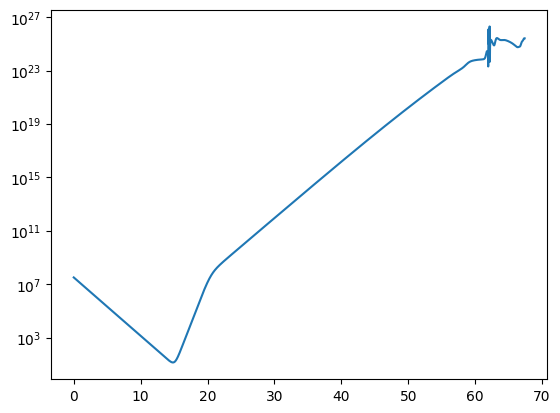

In [36]:
plt.plot(H.vals["N"], abs(rarr1[0]))
plt.yscale("log")